In [4]:
import pandas as pd
# Load data into pandas DataFrame from "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-01.parquet"
data = pd.read_parquet("/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-01.parquet")
data.head()


StatementMeta(, 48d158bf-7775-4e50-b12d-464c430a6de5, 6, Finished, Available, Finished)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [ ]:
df = spark.sql("SELECT * FROM Itransition_project.dbo.silver_taxi_daily_zone LIMIT 1000")
display(df)

StatementMeta(, , -1, SessionError, , SessionError)

InvalidHttpRequestToLivy: [TooManyRequestsForCapacity] This spark job can't be run because you have hit a spark compute or API rate limit. To run this spark job, cancel an active Spark job through the Monitoring hub, choose a larger capacity SKU, or try again later. HTTP status code: 430 {Learn more} HTTP status code: 430.

In [9]:
import pandas as pd

files = [
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-01.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-02.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-03.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-04.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-05.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-06.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-07.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-08.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-09.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-10.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-11.parquet",
    "/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-12.parquet",
]

use_cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "fare_amount",
    "total_amount",
    "trip_distance",
    "passenger_count",
]

df = pd.concat(
    [pd.read_parquet(f, columns=use_cols) for f in files],
    ignore_index=True
)

df["pickup_dt"]  = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["dropoff_dt"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")

df["pickup_date"]  = df["pickup_dt"].dt.date
df["dropoff_date"] = df["dropoff_dt"].dt.date

df["hour"] = df["pickup_dt"].dt.hour

df["trip_duration_min"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60


start_date = pd.to_datetime("2024-01-01").date()
end_date   = pd.to_datetime("2024-12-31").date()

df = df[
    (df["pickup_date"] >= start_date) &
    (df["pickup_date"] <= end_date)
]

df = df.dropna(subset=["pickup_date"])

taxi_daily_all = (
    df.groupby("pickup_date", as_index=False)
      .agg(
          trips_count=("pickup_date", "size"),
          avg_fare_usd=("total_amount", "mean"),
          avg_distance=("trip_distance", "mean"),
          avg_passengers=("passenger_count", "mean"),
      )
      .sort_values("pickup_date")
)

taxi_daily_all

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 11, Finished, Available, Finished)

,pickup_date,trips_count,avg_fare_usd,avg_distance,avg_passengers
0,2024-01-01,81013,30.153719,4.396814,1.551018
1,2024-01-02,75519,30.220157,4.119031,1.420578
2,2024-01-03,82427,28.602139,3.878400,1.381590
3,2024-01-04,102901,27.215586,3.310969,1.355976
4,2024-01-05,103178,26.446263,3.753546,1.371807
...,...,...,...,...,...
361,2024-12-27,84802,28.935630,4.596525,1.516450
362,2024-12-28,88213,26.939148,6.334677,1.551233
363,2024-12-29,79584,28.958192,3.925557,1.543517
364,2024-12-30,82021,28.852932,5.526977,1.466870


In [3]:
trips_by_hour = (df.groupby("hour")
                 .size()
                 .reset_index(name="trips")
                 .sort_values("hour"))
trips_by_hour.head()

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 5, Finished, Available, Finished)

,hour,trips
0,0,1192044
1,1,775046
2,2,504187
3,3,331790
4,4,243817


StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 6, Finished, Available, Finished)

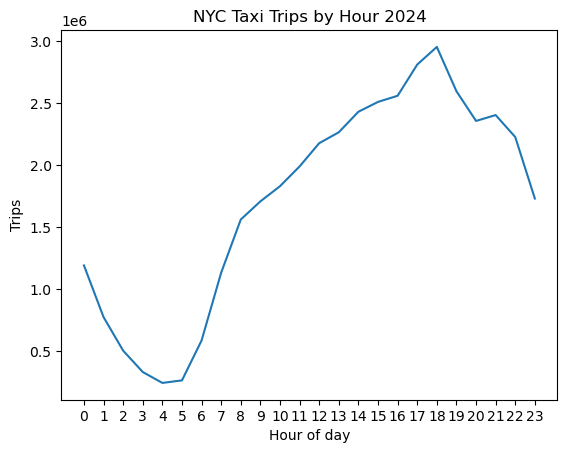

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trips_by_hour["hour"], trips_by_hour["trips"])
plt.xlabel("Hour of day")
plt.ylabel("Trips")
plt.title("NYC Taxi Trips by Hour 2024")
plt.xticks(range(0, 24))
plt.show()

In [5]:
trips_by_day = (df.groupby("pickup_date")
                .size()
                .reset_index(name="trips")
                .sort_values("pickup_date"))
trips_by_day.head()

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 7, Finished, Available, Finished)

,pickup_date,trips
0,2024-01-01,81013
1,2024-01-02,75519
2,2024-01-03,82427
3,2024-01-04,102901
4,2024-01-05,103178


StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 9, Finished, Available, Finished)

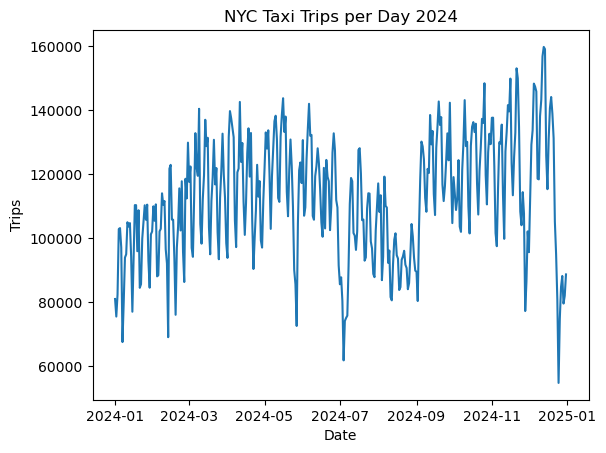

In [7]:
plt.figure()
plt.plot(pd.to_datetime(trips_by_day["pickup_date"]), trips_by_day["trips"])
plt.xlabel("Date")
plt.ylabel("Trips")
plt.title("NYC Taxi Trips per Day 2024")
plt.show()

In [10]:
revenue_by_day = (df.groupby("pickup_date")
                  .agg(
                      trips=("pickup_date", "size"),
                      total_revenue_usd=("total_amount", "sum"),
                      avg_fare_usd=("fare_amount", "mean"),
                      avg_total_usd=("total_amount", "mean"),
                      avg_distance=("trip_distance", "mean"),
                      avg_duration_min=("trip_duration_min", "mean")
                  )
                  .reset_index()
                  .sort_values("pickup_date"))

revenue_by_day.head()

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 12, Finished, Available, Finished)

,pickup_date,trips,total_revenue_usd,avg_fare_usd,avg_total_usd,avg_distance,avg_duration_min
0,2024-01-01,81013,2442843.25,21.788021,30.153719,4.396814,16.368330
1,2024-01-02,75519,2282196.02,20.967073,30.220157,4.119031,16.836004
2,2024-01-03,82427,2357588.48,19.664023,28.602139,3.878400,16.496110
3,2024-01-04,102901,2800511.06,18.421313,27.215586,3.310969,16.042530
4,2024-01-05,103178,2728672.52,17.832455,26.446263,3.753546,15.343437


StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 13, Finished, Available, Finished)

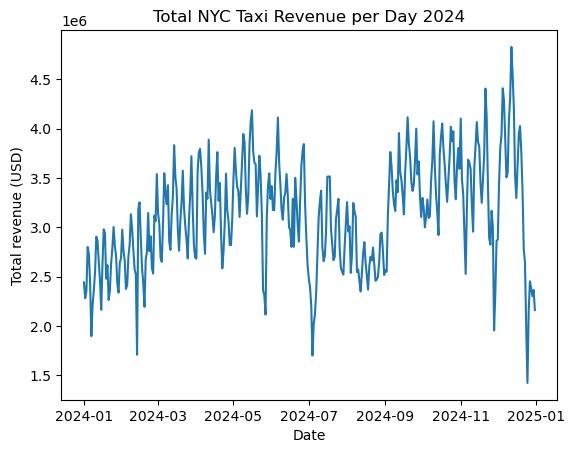

In [11]:
plt.figure()
plt.plot(pd.to_datetime(revenue_by_day["pickup_date"]), revenue_by_day["total_revenue_usd"])
plt.xlabel("Date")
plt.ylabel("Total revenue (USD)")
plt.title("Total NYC Taxi Revenue per Day 2024")
plt.show()

In [16]:
top_pickups = (df.groupby("PULocationID")
               .size()
               .reset_index(name="trips")
               .sort_values("trips", ascending=False))

top_pickups.head(10)

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 18, Finished, Available, Finished)

,PULocationID,trips
129,132,1989986
234,237,1915438
158,161,1914605
233,236,1729895
159,162,1418846
227,230,1391157
183,186,1362156
139,142,1314690
135,138,1295499
167,170,1176580


In [19]:
import pandas as pd
# Load data into pandas DataFrame from "/lakehouse/default/Files/Bronze_taxi/taxi_zone_lookup.csv"
zone = pd.read_csv("/lakehouse/default/Files/Bronze_taxi/taxi_zone_lookup.csv")
zone

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 21, Finished, Available, Finished)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [20]:
zones_small = zone[["LocationID", "Borough", "Zone", "service_zone"]].rename(
    columns={"LocationID": "PULocationID"}
)

top_pickups_with_zone = (
    top_pickups
    .merge(zones_small, on="PULocationID", how="left")
)

top_pickups_manhattan = (
    top_pickups_with_zone
    [top_pickups_with_zone["Borough"] == "Manhattan"]
)

top_pickups_with_zone

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 22, Finished, Available, Finished)

,PULocationID,trips,Borough,Zone,service_zone
0,132,1989986,Queens,JFK Airport,Airports
1,237,1915438,Manhattan,Upper East Side South,Yellow Zone
2,161,1914605,Manhattan,Midtown Center,Yellow Zone
3,236,1729895,Manhattan,Upper East Side North,Yellow Zone
4,162,1418846,Manhattan,Midtown East,Yellow Zone
...,...,...,...,...,...
258,199,17,Bronx,Rikers Island,Boro Zone
259,5,7,Staten Island,Arden Heights,Boro Zone
260,105,4,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
261,99,4,Staten Island,Freshkills Park,Boro Zone


In [21]:
top_pickups_manhattan = (
    top_pickups_with_zone
    [top_pickups_with_zone["Borough"] == "Manhattan"]
)

top_pickups_manhattan

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 23, Finished, Available, Finished)

,PULocationID,trips,Borough,Zone,service_zone
1,237,1915438,Manhattan,Upper East Side South,Yellow Zone
2,161,1914605,Manhattan,Midtown Center,Yellow Zone
3,236,1729895,Manhattan,Upper East Side North,Yellow Zone
4,162,1418846,Manhattan,Midtown East,Yellow Zone
5,230,1391157,Manhattan,Times Sq/Theatre District,Yellow Zone
...,...,...,...,...,...
195,194,1949,Manhattan,Randalls Island,Yellow Zone
222,153,752,Manhattan,Marble Hill,Boro Zone
226,128,412,Manhattan,Inwood Hill Park,Boro Zone
232,120,282,Manhattan,Highbridge Park,Boro Zone


In [22]:
top_pickups_manhattan[top_pickups_manhattan['PULocationID'] == 90]

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 24, Finished, Available, Finished)

,PULocationID,trips,Borough,Zone,service_zone
25,90,652646,Manhattan,Flatiron,Yellow Zone


In [4]:
import pandas as pd

files = [f"/lakehouse/default/Files/Bronze_taxi/yellow_tripdata_2024-{m:02d}.parquet" for m in range(1, 13)]

use_cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "total_amount",
    "trip_distance",
    "fare_amount"
]

# 1) read taxi
df = pd.concat([pd.read_parquet(f, columns=use_cols) for f in files], ignore_index=True)

# 2) datetimes + basic cleaning
df["pickup_dt"]  = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["dropoff_dt"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")

df = df.dropna(subset=["pickup_dt"])
df["date"] = df["pickup_dt"].dt.date
df["hour"] = df["pickup_dt"].dt.hour
df["trip_duration_min"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60

# 3) strict date filter (remove anomalous timestamps)
start = pd.Timestamp("2024-01-01")
end = pd.Timestamp("2025-01-01")  

df = df[(df["pickup_dt"] >= start) & (df["pickup_dt"] < end)].copy()

# 4) join zone lookup
zones = pd.read_csv("/lakehouse/default/Files/Bronze_taxi/taxi_zone_lookup.csv")

zones_p = zones[["LocationID", "Borough", "Zone"]].rename(columns={"LocationID": "PULocationID", "Zone": "pickup_zone", "Borough": "Borough_p"})
df = df.merge(zones_p, on="PULocationID", how="left")

zones_d = zones[["LocationID", "Borough", "Zone"]].rename(columns={"LocationID": "DOLocationID", "Zone": "destination_zone", "Borough": "Borough_d"})
df = df.merge(zones_d, on="DOLocationID", how="left")

# 5) Manhattan only (as you decided)
# df = df[df["Borough"] == "Manhattan"].copy()

# silver table daily
silver_taxi_daily_zone = (
    df.groupby(["date", "Borough_p", "PULocationID"], as_index=False)
      .agg(
          trips_count=("date", "size"),
          avg_total_amount_usd=("total_amount", "mean"),
          avg_trip_distance=("trip_distance", "mean"),
          avg_duration_min=("trip_duration_min", "mean"),
      )
      .sort_values(["date"])
)

# silver table hourle
silver_taxi_hourly_zone = (
    df.groupby(["date", "hour", "Borough_p", "PULocationID"], as_index=False)
      .agg(
          trips_count=("date", "size"),
          avg_total_amount_usd=("total_amount", "mean"),
      )
      .sort_values(["date", "hour"])
)

# dim table about zone
dim_taxi_zone = zones.copy()

silver_taxi_daily_zone.head()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 6, Finished, Available, Finished)

,date,Borough_p,PULocationID,trips_count,avg_total_amount_usd,avg_trip_distance,avg_duration_min
0,2024-01-01,Bronx,3,1,36.770000,9.660000,18.166667
147,2024-01-01,Manhattan,232,321,28.038660,3.340623,16.277778
148,2024-01-01,Manhattan,233,857,26.432555,3.122100,12.842396
149,2024-01-01,Manhattan,234,1694,22.419044,2.365130,17.434662
150,2024-01-01,Manhattan,236,1763,20.691480,2.251123,9.862554


In [5]:
df.isna().sum()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 7, Finished, Available, Finished)

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
PULocationID                  0
DOLocationID                  0
total_amount                  0
trip_distance                 0
fare_amount                   0
pickup_dt                     0
dropoff_dt                    0
date                          0
hour                          0
trip_duration_min             0
Borough_p                 24001
pickup_zone              122200
Borough_d                183903
destination_zone         186350
dtype: int64

In [15]:
silver_taxi_hourly_zone.head()

StatementMeta(, f81113bf-11b1-479b-adb7-c54f8577035a, 17, Finished, Available, Finished)

,date,hour,Borough_p,PULocationID,trips_count,avg_total_amount_usd
0,2024-01-01,0,Bronx,18,2,19.770000
1,2024-01-01,0,Bronx,20,1,10.400000
2,2024-01-01,0,Bronx,60,1,13.230000
3,2024-01-01,0,Bronx,69,1,26.090000
4,2024-01-01,0,Bronx,78,3,23.816667


In [15]:
dim_taxi_zone.head()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 17, Finished, Available, Finished)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [30]:
import pyspark.sql.functions as F

# pandas -> spark
spark_daily = spark.createDataFrame(silver_taxi_daily_zone)
spark_hourly = spark.createDataFrame(silver_taxi_hourly_zone)
spark_dim = spark.createDataFrame(dim_taxi_zone)

# write as Delta tables into Lakehouse (Silver)
spark_daily.write.mode("append").saveAsTable("silver_taxi_daily_zone")
spark_hourly.write.mode("append").saveAsTable("silver_taxi_hourly_zone")
spark_dim.write.mode("append").saveAsTable("dim_taxi_zone")

StatementMeta(, 7025ce44-eb0d-40b9-92e9-f1b134afd0d9, 32, Finished, Available, Finished)

In [13]:
trips_by_hour = (df.groupby("hour")
                 .size()
                 .reset_index(name="trips")
                 .sort_values("hour"))

revenue_by_day = (df.groupby("date")
                  .agg(
                      trips=("date", "size"),
                      total_revenue_usd=("total_amount", "sum"),
                      avg_fare_usd=("fare_amount", "mean"),
                      avg_total_usd=("total_amount", "mean"),
                      avg_distance=("trip_distance", "mean"),
                      avg_duration_min=("trip_duration_min", "mean")
                  )
                  .reset_index()
                  .sort_values("date"))

top_pickups = (df.groupby(["PULocationID", "Borough_p", ""])
               .size()
               .reset_index(name="trips")
               .sort_values("trips", ascending=False))

trips_by_hour.head()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 15, Finished, Available, Finished)

,hour,trips
0,0,1192044
1,1,775046
2,2,504187
3,3,331790
4,4,243817


In [14]:
revenue_by_day.head()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 16, Finished, Available, Finished)

,date,trips,total_revenue_usd,avg_fare_usd,avg_total_usd,avg_distance,avg_duration_min
0,2024-01-01,81013,2442843.25,21.788021,30.153719,4.396814,16.368330
1,2024-01-02,75519,2282196.02,20.967073,30.220157,4.119031,16.836004
2,2024-01-03,82427,2357588.48,19.664023,28.602139,3.878400,16.496110
3,2024-01-04,102901,2800511.06,18.421313,27.215586,3.310969,16.042530
4,2024-01-05,103178,2728672.52,17.832455,26.446263,3.753546,15.343437


In [12]:
top_pickups.head()

StatementMeta(, 5395b26d-de44-49bb-b25e-8c93719322b5, 14, Finished, Available, Finished)

,PULocationID,Borough_p,trips
129,132,Queens,1989986
234,237,Manhattan,1915438
158,161,Manhattan,1914605
233,236,Manhattan,1729895
159,162,Manhattan,1418846
